In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [3]:
!pip install -q mlflow
!pip install -q python-dotenv

In [4]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [5]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

In [6]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [7]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2024.pkl'))

In [8]:
df.head()

,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,FG%,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [9]:
cols_tot_rank = [col for col in df.columns if '_tot' in col or '_rank' in col]
cols_to_drop = ['G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos', 'Age', 'G', 'GS', 'FGA_pg', 'FG%', '3P_pg', '3PA_pg', '3P%', '2PA_pg', '2P%', 'eFG%', 'FT%', 'ORB_pg', 'DRB_pg', 'PF_pg', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'OBPM', 'DBPM']
cols_to_drop += cols_tot_rank
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']

In [10]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('AdjustColumns', prep.AdjustCols(cols_to_adjust = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [11]:
df = pipe_clean.fit_transform(df)

In [12]:
df.head()

,,MP_pg,FG_pg,2P_pg,FT_pg,FTA_pg,TRB_pg,AST_pg,STL_pg,BLK_pg,TOV_pg,...,USG%,OWS,DWS,WS,WS/48,BPM,VORP,%W,%G,Share
Player,Season,,,,,,,,,,,,,,,,,,,,,
Kareem Abdul-Jabbar,1982,35.2,9.9,9.9,4.1,5.8,8.7,3.0,0.8,2.7,3.0,...,0.256,6.9,3.9,10.7,0.192,5.0,4.7,0.695,0.927,0.045
Alvan Adams,1982,30.3,6.4,6.4,2.3,2.9,7.4,4.5,1.4,1.0,2.5,...,0.228,2.5,4.7,7.2,0.144,3.6,3.4,0.561,0.963,0.000
Mark Aguirre,1982,28.8,7.5,7.0,3.3,4.8,4.9,3.2,0.7,0.4,2.6,...,0.298,1.0,0.8,1.9,0.061,0.7,1.0,0.341,0.622,0.000
Danny Ainge,1982,10.6,1.5,1.4,1.1,1.2,1.1,1.6,0.7,0.1,1.0,...,0.215,-0.3,0.8,0.5,0.042,-2.7,-0.1,0.768,0.646,0.000
Tiny Archibald,1982,31.9,4.5,4.4,3.5,4.6,1.7,8.0,0.8,0.0,2.6,...,0.179,3.4,1.8,5.2,0.115,0.1,1.1,0.768,0.829,0.000


In [13]:
df.columns

Index(['MP_pg', 'FG_pg', '2P_pg', 'FT_pg', 'FTA_pg', 'TRB_pg', 'AST_pg',
       'STL_pg', 'BLK_pg', 'TOV_pg', 'PTS_pg', '%GS', 'PER', 'USG%', 'OWS',
       'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '%W', '%G', 'Share'],
      dtype='object')

In [14]:
len(df[df.index.get_level_values(1) > 2017]) / len(df)

0.20560102029971303

In [15]:
val_df = df[df.index.get_level_values(1) > 2017]
dev_df = df[df.index.get_level_values(1) <= 2017]

In [16]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [17]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [18]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [19]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [20]:
datasets['val']

,,MP_pg,FG_pg,2P_pg,FT_pg,FTA_pg,TRB_pg,AST_pg,STL_pg,BLK_pg,TOV_pg,...,PER,USG%,OWS,DWS,WS,WS/48,BPM,VORP,%W,%G
Player,Season,,,,,,,,,,,,,,,,,,,,,
Álex Abrines,2018,15.1,1.5,0.4,0.5,0.6,1.5,0.4,0.5,0.1,0.3,...,9.0,0.127,1.3,1.0,2.2,0.094,-1.5,0.1,0.585,0.915
Quincy Acy,2018,19.4,1.9,0.4,0.7,0.9,3.7,0.8,0.5,0.4,0.9,...,8.2,0.144,-0.1,1.1,1.0,0.036,-2.5,-0.2,0.341,0.854
Steven Adams,2018,32.7,5.9,5.9,2.1,3.8,9.0,1.2,1.2,1.0,1.7,...,20.6,0.167,6.7,3.0,9.7,0.187,1.1,2.0,0.585,0.927
Bam Adebayo,2018,19.8,2.5,2.5,1.9,2.6,5.5,1.5,0.5,0.6,1.0,...,15.7,0.159,2.3,1.9,4.2,0.148,-0.4,0.6,0.537,0.841
Arron Afflalo,2018,12.9,1.2,0.7,0.4,0.5,1.2,0.6,0.1,0.2,0.4,...,5.8,0.125,-0.1,0.2,0.1,0.009,-5.4,-0.6,0.305,0.646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Danny Green,2024,9.0,0.0,0.0,0.0,0.0,1.0,0.5,0.5,0.0,0.0,...,5.0,0.050,0.0,0.0,0.0,0.000,-6.6,0.0,0.573,0.024
Ron Harper Jr.,2024,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,5.0,0.050,0.0,0.0,0.0,0.000,-8.8,0.0,0.305,0.012
Justin Jackson,2024,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.050,0.0,0.0,0.0,0.000,-7.5,0.0,0.683,0.024


In [21]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [22]:
mlflow.set_experiment('Random Forest v2')

<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/7', creation_time=1730481717687, experiment_id='7', last_update_time=1730481717687, lifecycle_stage='active', name='Random Forest v2', tags={}>

In [23]:
param_grid = {
    'max_depth': [10],
    'min_samples_split': [10],
    'max_features': [.5],
    'n_estimators': [250]
    }

In [24]:
with mlflow.start_run():
    estimator = RandomForestRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_rf(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val']))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=250; total time=  13.3s
[CV] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=250; total time=  13.2s
[CV] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=250; total time=  14.5s
[CV] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=250; total time=  13.4s
[CV] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=250; total time=  13.3s
[CV] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=250; total time=  13.2s
[CV] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=250; total time=  13.2s
[CV] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=250; total time=  13.5s
[CV] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=250; total time=  13.8s
[CV] END max_depth=10, max_features=0.5

2024/12/14 11:25:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run nebulous-finch-891 at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/7/runs/968e5c3750314f6dba8a9d7c20797aad
🧪 View experiment at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/7


In [25]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.009109,0.011944,0.026467
R2,0.996657,0.984621,0.767655


In [26]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

In [27]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Share,PredShare
Player,Season,,
James Harden,2018,0.955,0.667167
LeBron James,2018,0.731,0.378550
Anthony Davis,2018,0.441,0.162363
Damian Lillard,2018,0.205,0.099518
Russell Westbrook,2018,0.075,0.204570
Giannis Antetokounmpo,2018,0.074,0.122207
Kevin Durant,2018,0.065,0.152484
DeMar DeRozan,2018,0.032,0.012720
LaMarcus Aldridge,2018,0.006,0.076586


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2019,0.932,0.686840
James Harden,2019,0.768,0.607404
Paul George,2019,0.352,0.123845
Nikola Jokić,2019,0.210,0.185993
Stephen Curry,2019,0.173,0.143691
Damian Lillard,2019,0.068,0.053224
Joel Embiid,2019,0.049,0.154711
Kevin Durant,2019,0.025,0.161723
Kawhi Leonard,2019,0.013,0.211296


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2020,0.952,0.556704
LeBron James,2020,0.746,0.377336
James Harden,2020,0.363,0.371889
Luka Dončić,2020,0.198,0.192536
Kawhi Leonard,2020,0.166,0.146672
Anthony Davis,2020,0.081,0.262279
Chris Paul,2020,0.026,0.008057
Damian Lillard,2020,0.023,0.144610
Nikola Jokić,2020,0.018,0.052819


,,Share,PredShare
Player,Season,,
Nikola Jokić,2021,0.961,0.533569
Joel Embiid,2021,0.580,0.173859
Stephen Curry,2021,0.449,0.210548
Giannis Antetokounmpo,2021,0.345,0.215333
Chris Paul,2021,0.138,0.007811
Luka Dončić,2021,0.042,0.181208
Damian Lillard,2021,0.038,0.125405
Julius Randle,2021,0.020,0.008647
Derrick Rose,2021,0.010,0.000118


,,Share,PredShare
Player,Season,,
Nikola Jokić,2022,0.875,0.456746
Joel Embiid,2022,0.706,0.341277
Giannis Antetokounmpo,2022,0.595,0.373557
Devin Booker,2022,0.216,0.065603
Luka Dončić,2022,0.146,0.240281
Jayson Tatum,2022,0.043,0.070934
Ja Morant,2022,0.010,0.159339
Stephen Curry,2022,0.004,0.017253
Chris Paul,2022,0.002,0.021062


,,Share,PredShare
Player,Season,,
Joel Embiid,2023,0.915,0.474246
Nikola Jokić,2023,0.674,0.447415
Giannis Antetokounmpo,2023,0.606,0.412363
Jayson Tatum,2023,0.280,0.237194
Shai Gilgeous-Alexander,2023,0.046,0.163791
Donovan Mitchell,2023,0.030,0.106975
Domantas Sabonis,2023,0.027,0.071166
Luka Dončić,2023,0.010,0.257352
Stephen Curry,2023,0.005,0.090501


,,Share,PredShare
Player,Season,,
Nikola Jokić,2024,0.935,0.754333
Shai Gilgeous-Alexander,2024,0.646,0.573338
Luka Dončić,2024,0.572,0.405665
Giannis Antetokounmpo,2024,0.194,0.342915
Jalen Brunson,2024,0.143,0.108740
Jayson Tatum,2024,0.087,0.173921
Anthony Edwards,2024,0.018,0.031691
Domantas Sabonis,2024,0.003,0.126136
Kevin Durant,2024,0.001,0.055117


No contenders results:


,,Share,PredShare
Player,Season,,
Álex Abrines,2018,0.0,0.000048
Quincy Acy,2018,0.0,0.000048
Steven Adams,2018,0.0,0.003038
Bam Adebayo,2018,0.0,0.000049
Arron Afflalo,2018,0.0,0.000048
...,...,...,...
Danny Green,2024,0.0,0.000048
Ron Harper Jr.,2024,0.0,0.000048
Justin Jackson,2024,0.0,0.000048


In [28]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Share,PredShare
Player,Season,,
Anthony Davis,2019,0.0,0.120923
Kevin Durant,2021,0.0,0.153371
Trae Young,2022,0.0,0.119629
Kevin Durant,2023,0.0,0.134788
Damian Lillard,2023,0.0,0.146757
Joel Embiid,2024,0.0,0.276885
Anthony Davis,2024,0.0,0.123102


<Axes: title={'center': 'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

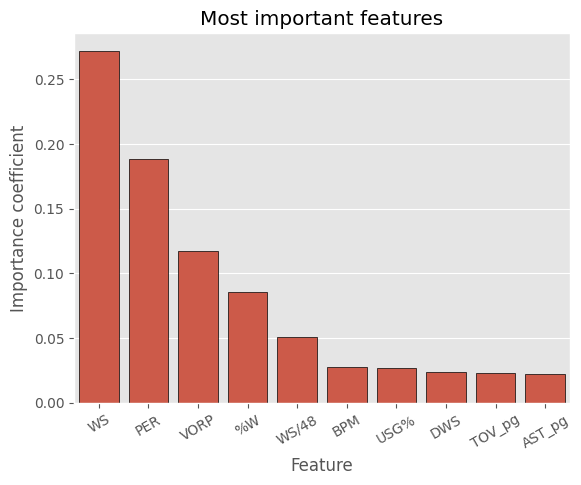

In [29]:
mod.display_feature_importances(best_model)

In [30]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

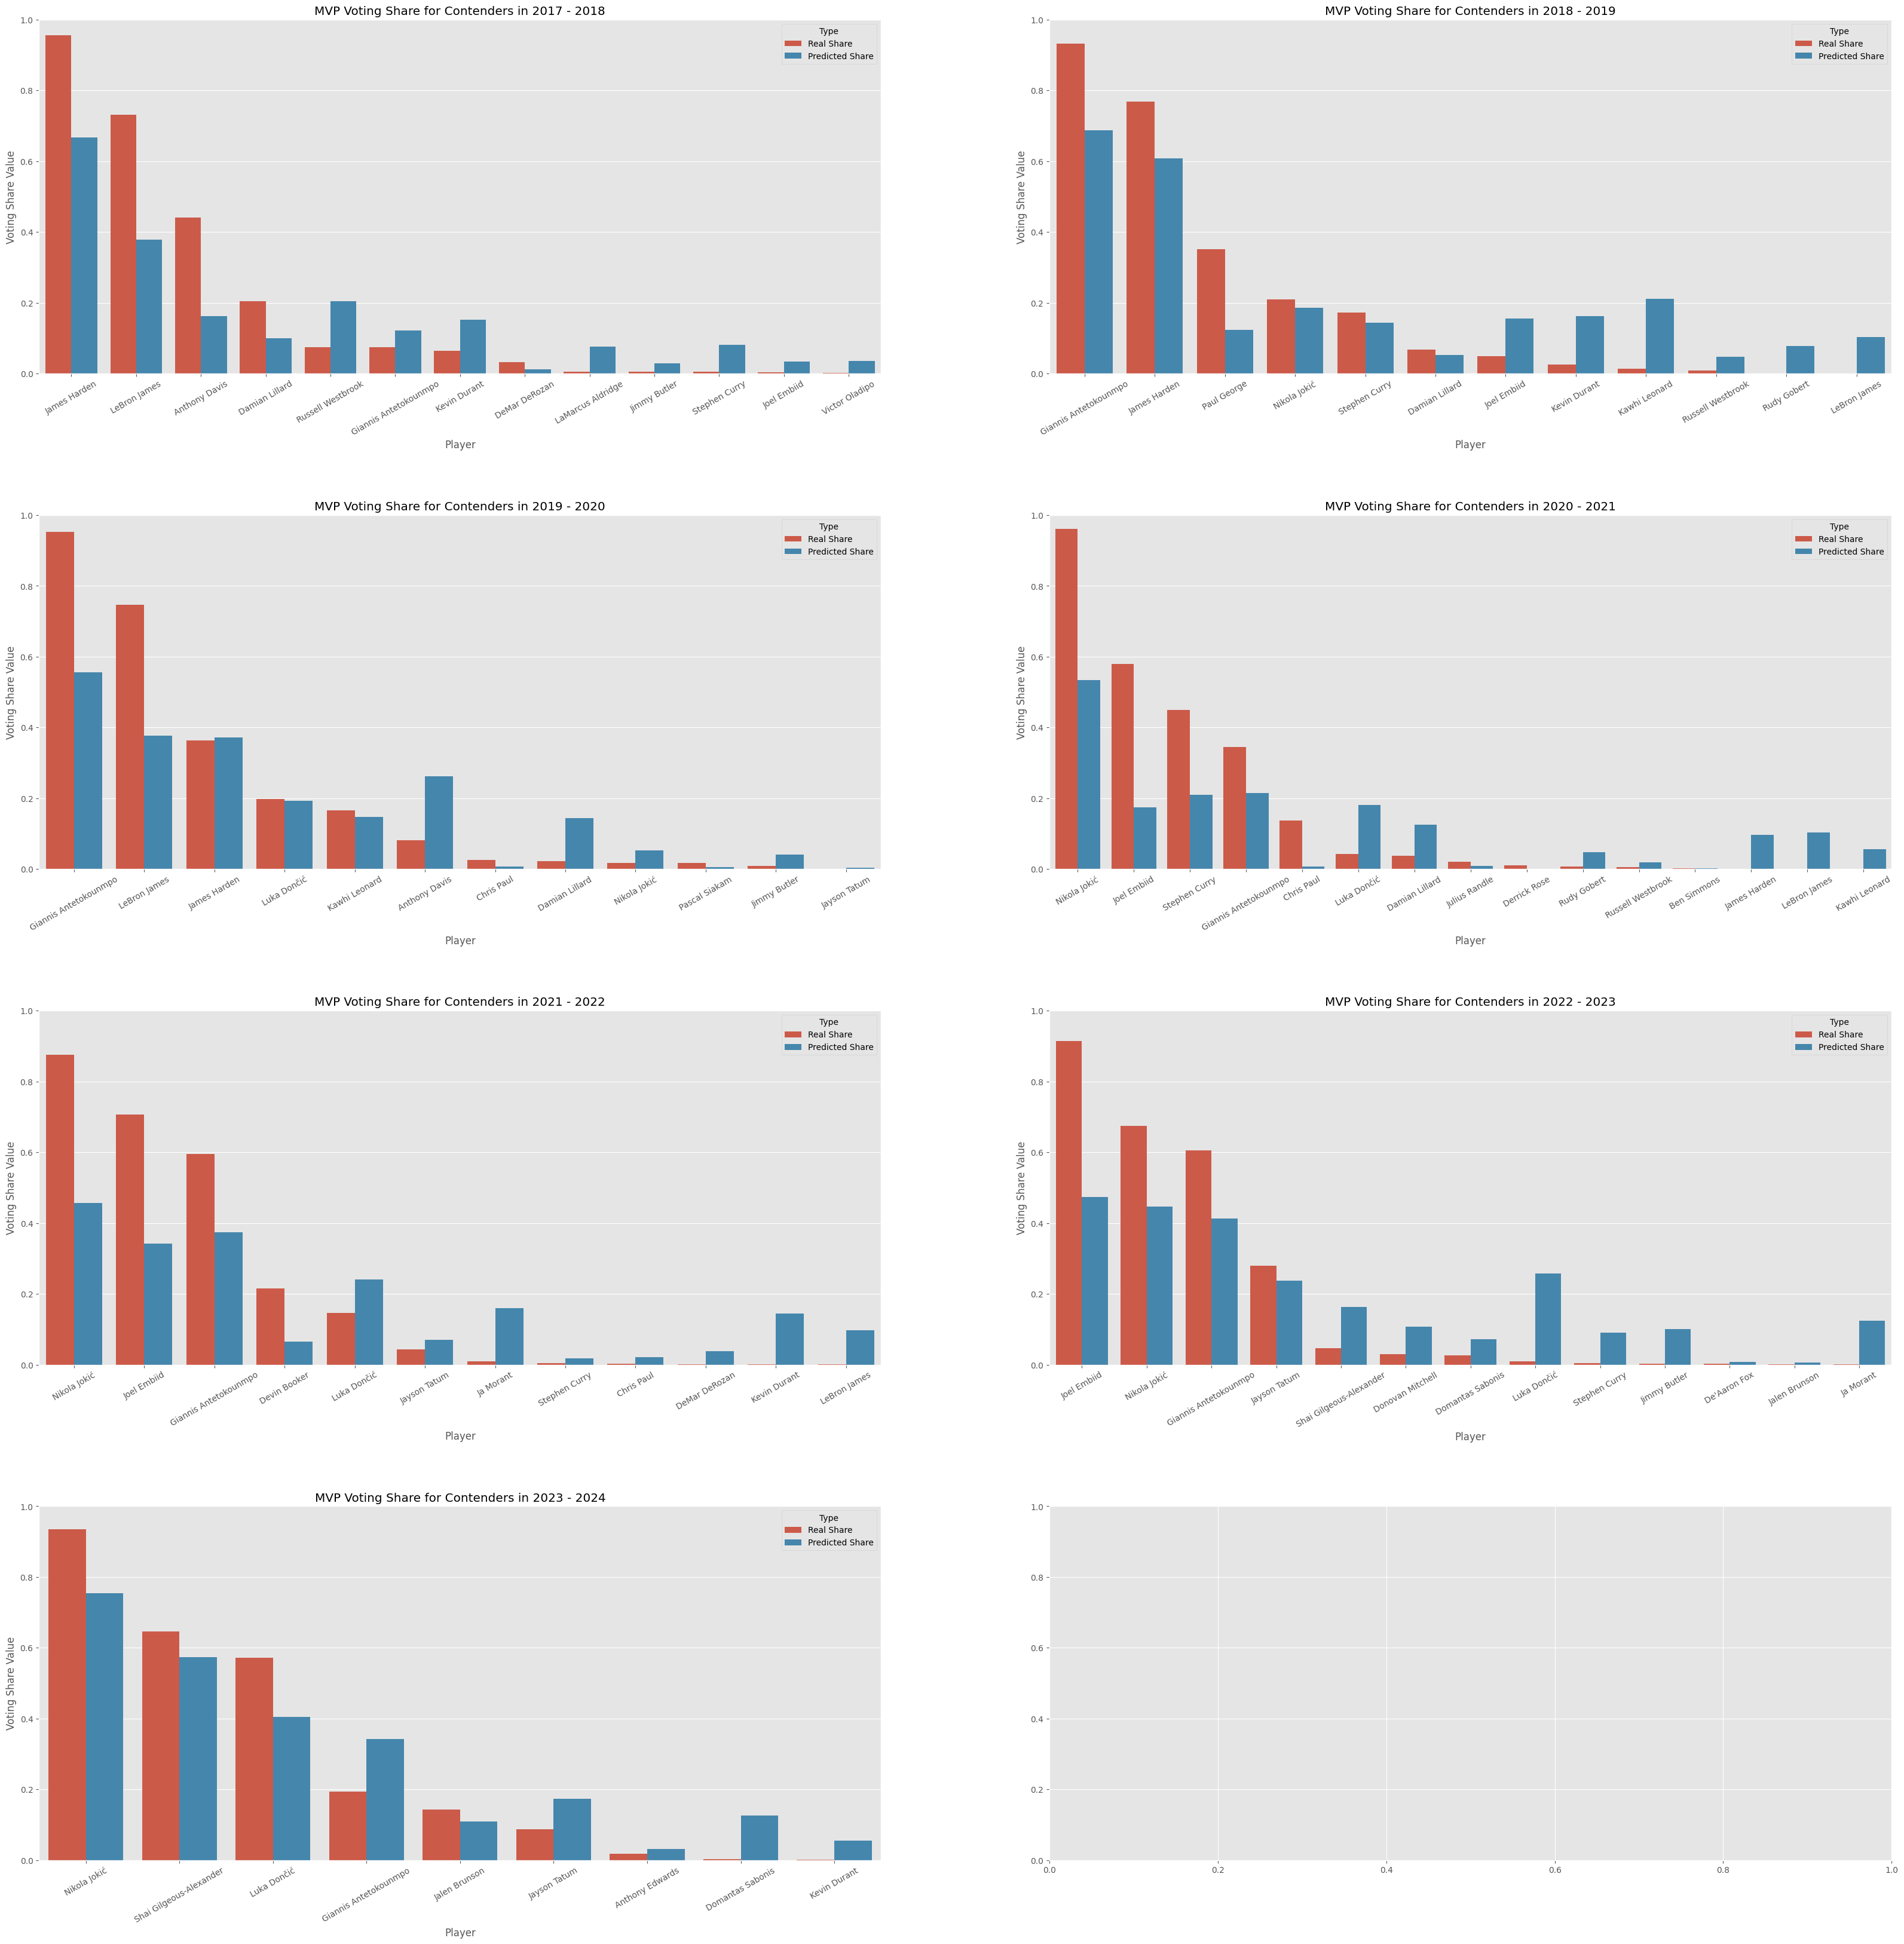

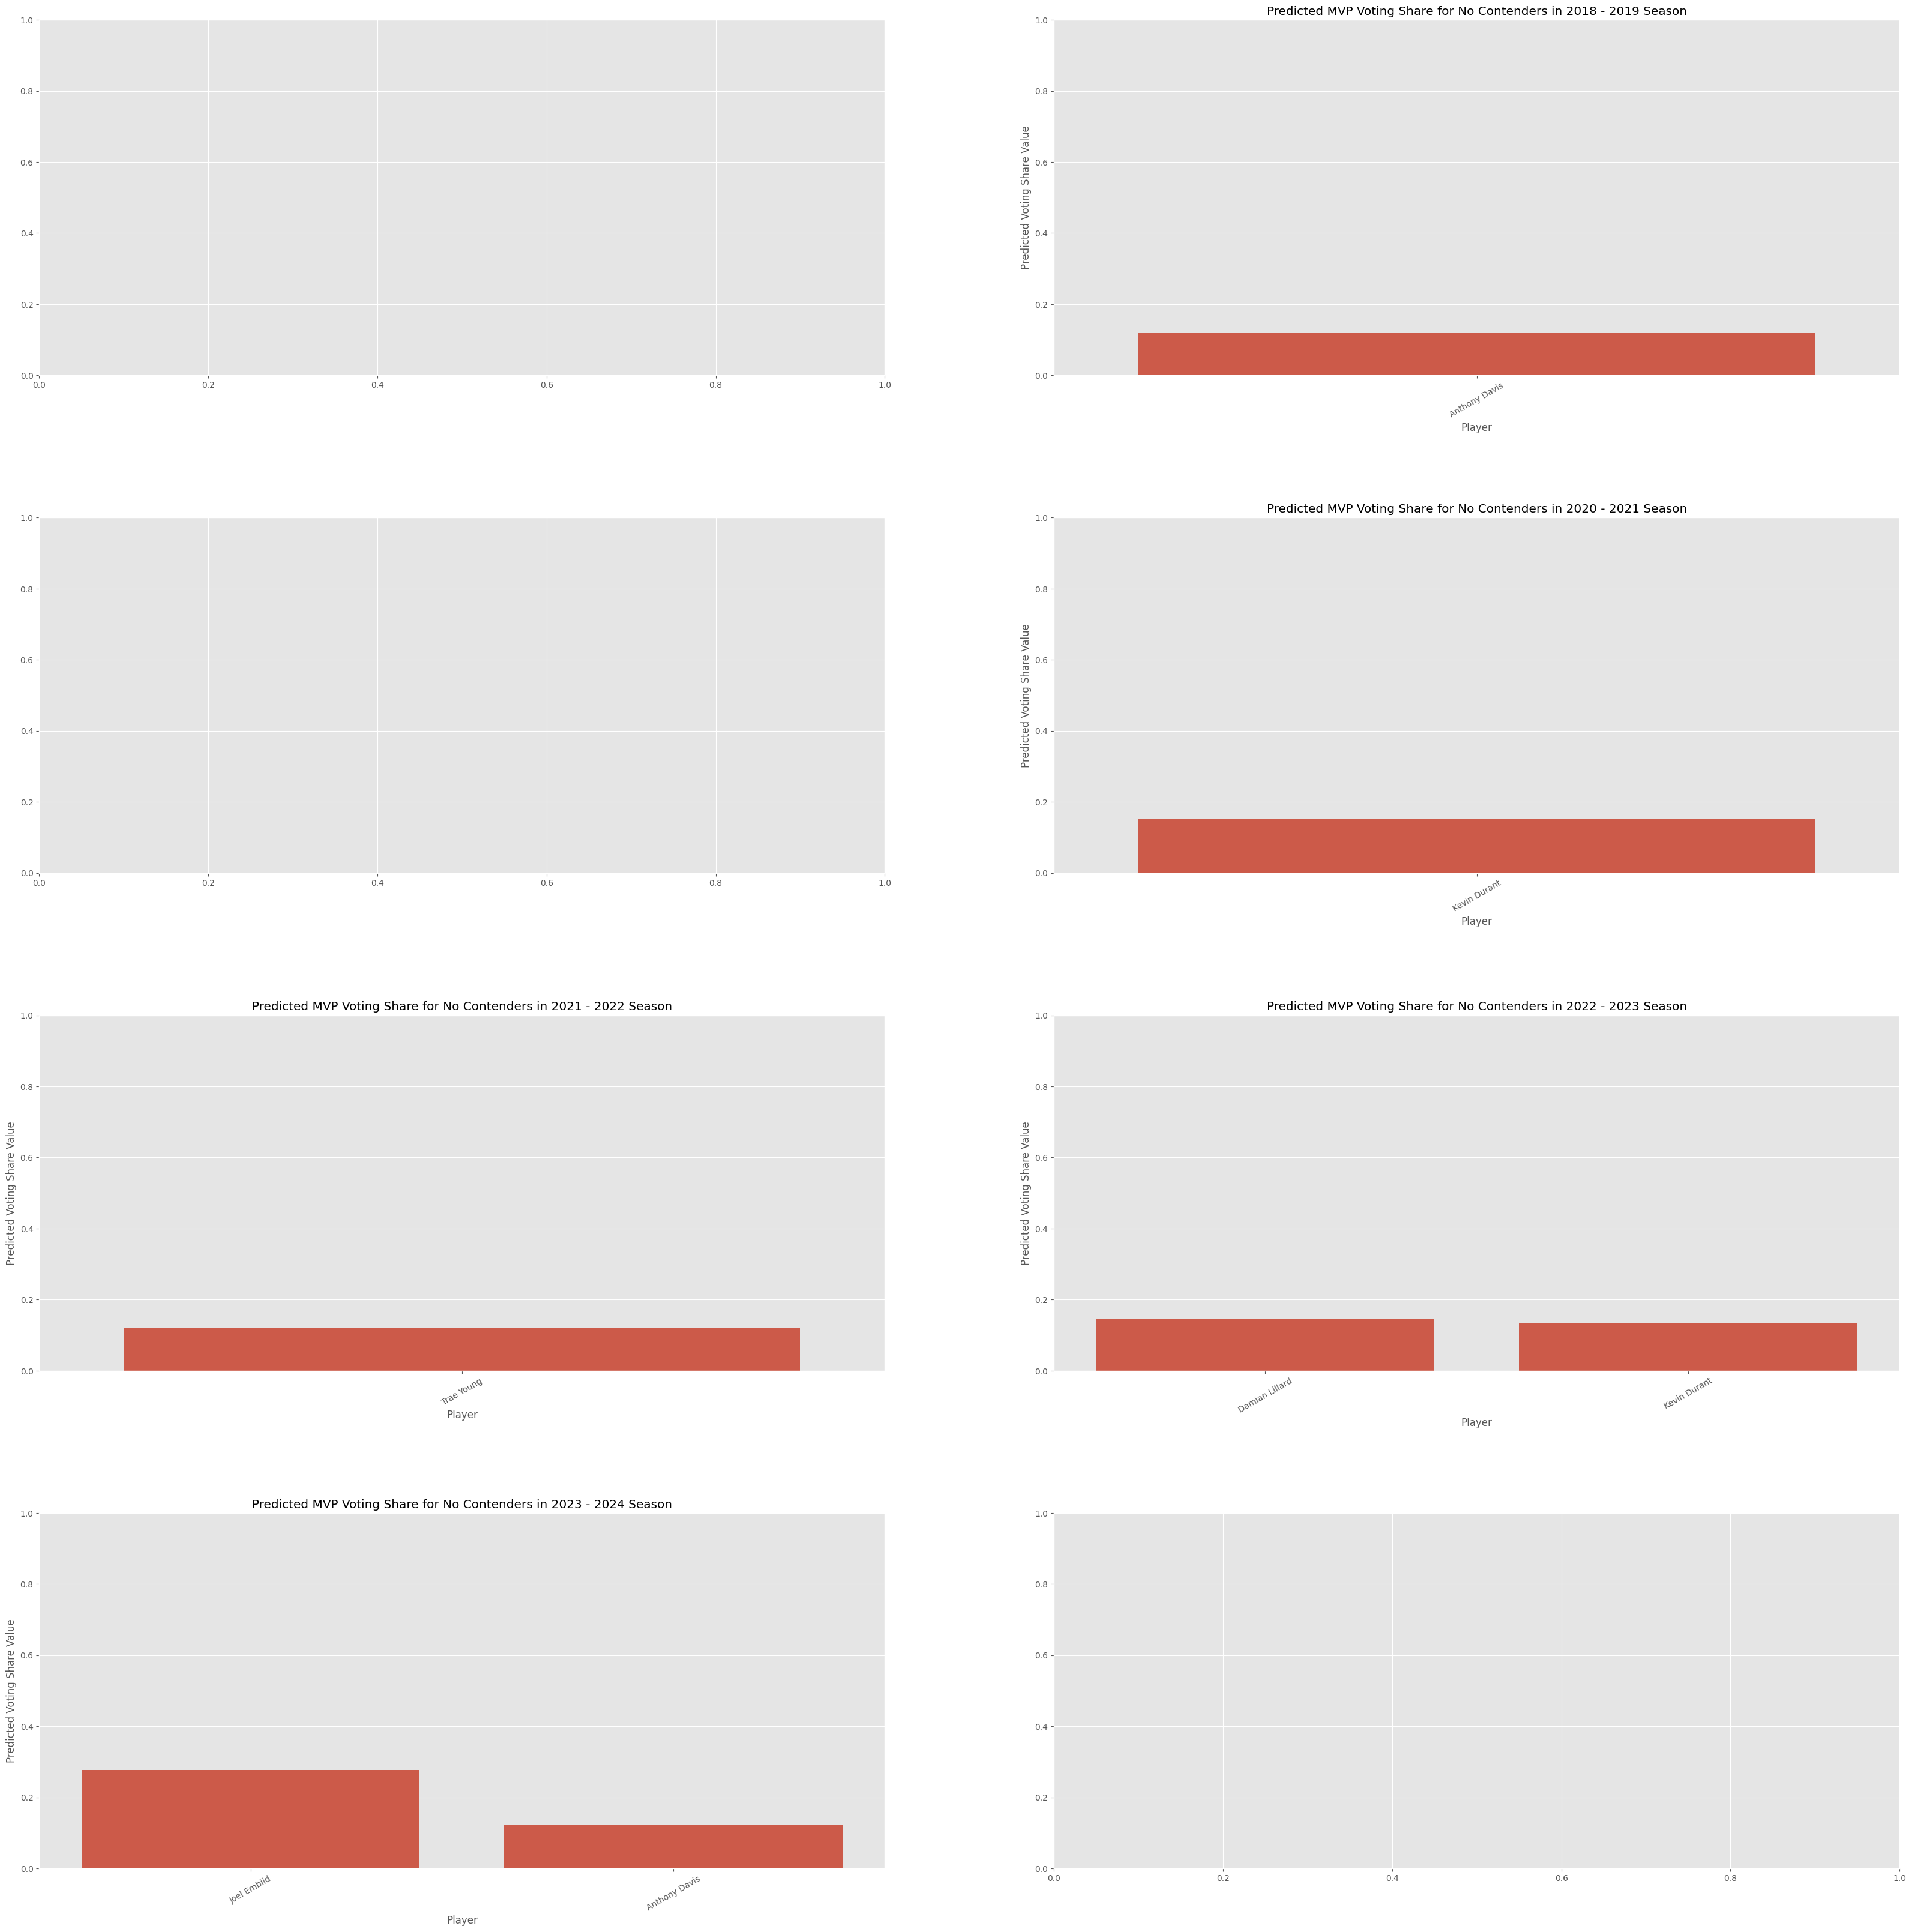

In [31]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'])